#Setting up required packages in our environment

Please note Colab supports transformers version 4.31.0 but same notebook if executed in Kaggle may require higher version such as 4.33.0 or greater.

---



In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7
!pip install evaluate
!pip install rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 856.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194

#Lets Load everything that we need for our project


In [ ]:
import os
import torch
from datasets import load_dataset, Dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer
import pandas as pd
import evaluate


#Llama2 Prompt Format For Text Generation

Since the free resource from google colab offers only 15gb of graphics compute which is hardly enough to store the weights of llama 2 model, we use PEFT techniques like LORA and QLORA. QLORA further quantizes into 4 bit making it much more effiecient while training on gpu.

The LLama 2 model has specific prompt format to be followed like below:


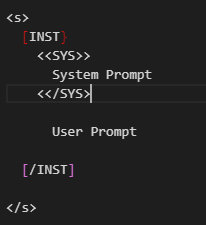

Anything between SYS tag are to provide an instruction to the model. If not can be left blank or only inclyde INST tags. 's' tags represent the session of a conversation for this chat based model.

---



#Fine Tuning Process


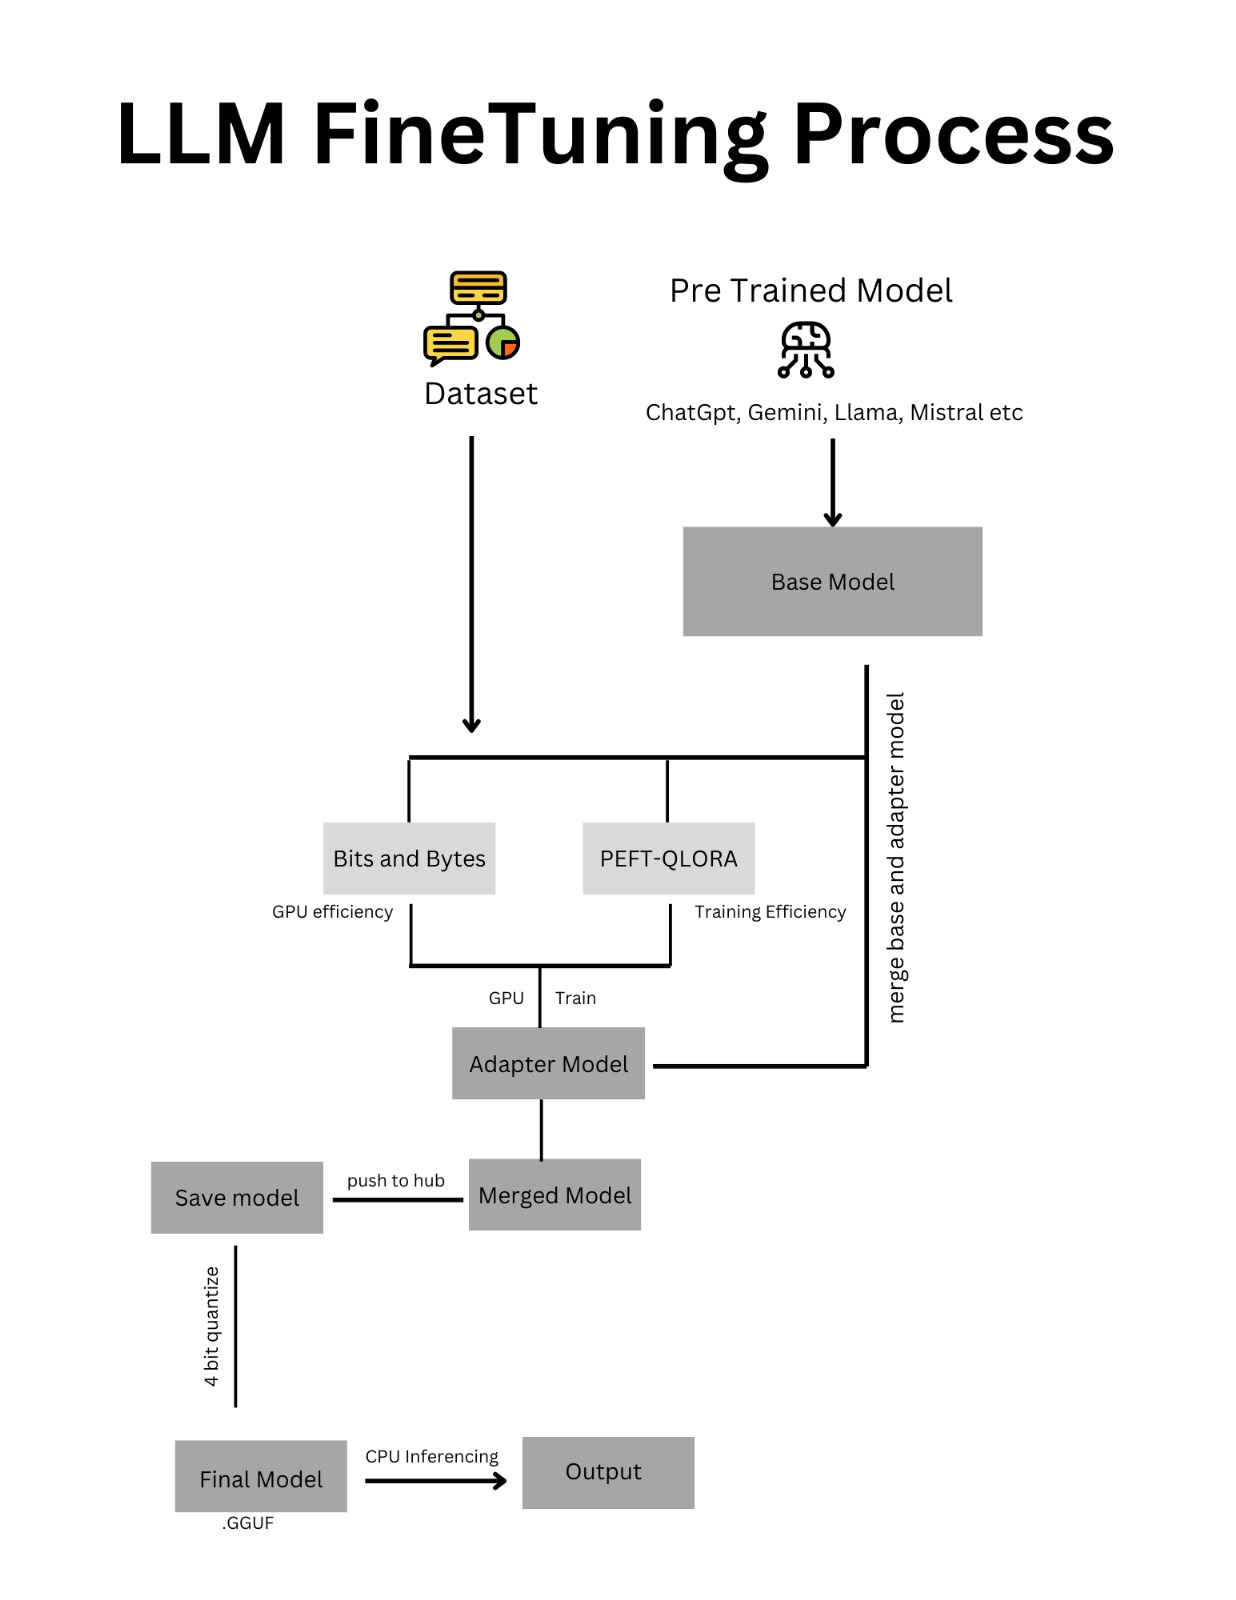

#Let's setup our configurations and define our params

In [ ]:
# Using Open source llama 2 Model from Hugging Face hub
model_name = "NousResearch/Llama-2-7b-chat-hf"
# model_name = "google/flan-t5-base"
# model_name = "facebook/opt-350m"
# model_name = "microsoft/DialoGPT-medium"
# Fine-tuned model name
new_model = "finetuned_chat"

# QLoRA Parameters
lora_r = 64              # attention dimension
lora_alpha = 16          # scaling factor
lora_dropout = 0.1       # dropout probability

# Bits and Bytes Parameters
use_4bit = True          # using 4-bit precision
bnb_4bit_compute_dtype = "float16"  #  dtype for 4-bit models
bnb_4bit_quant_type = "nf4"  # Quantization type
use_nested_quant = False # disabling nested quantization

# Training Arguments
output_dir = "./results"

num_train_epochs = 1             # number of training epochs
fp16 = False                       # fp16 training status
bf16 = False                       # bf16 training status
per_device_train_batch_size = 4    # traun batch size per GPU
per_device_eval_batch_size = 4     # eval batch size per GPU
gradient_accumulation_steps = 1    # steps to accumulate gradients
gradient_checkpointing = True      # enable gradient checkpointing
max_grad_norm = 0.3                # gradient clipping
learning_rate = 2e-4               # initial learning rate
weight_decay = 0.001               # weight decay
optim = "paged_adamw_32bit"        # optimizer type
lr_scheduler_type = "cosine"       # learning rate schedule
max_steps = -1                     # override for num_train_epochs
warmup_ratio = 0.03                # linear warmup ratio
group_by_length = True             # group sequences by length
save_steps = 0                     # checkpoint save frequency
logging_steps = 25                 # logging frequency

# SFT Parameters
max_seq_length = None              # max sequence length
packing = False                    # pack short examples
device_map = {"": 0}               # load model on GPU 0


#Loading our dataset from huggingface notechat by akemiH

dataset link - https://huggingface.co/datasets/akemiH/NoteChat

In [ ]:

ds = load_dataset("akemiH/NoteChat")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/207001 [00:00<?, ? examples/s]


*  The base model is fine-tuned using the NoteChatdataset.


*  PEFT methods (QLoRAand Bits and Bytes) are used for efficient training.

*  The fine-tuned model is then quantized to optimize for text generation.



*  The final model is 4-bit quantized can be downloaded and deployed for CPU inferencing.







In [ ]:

#loading dataset here
def format(text):
    cleaned = text.replace('\n', ' ').replace('  ', ' ')
    cleaned = cleaned.replace('Doctor:', '### Doctor:').replace('Patient:', '### Patient:').strip()

    return cleaned


def format_conversation(ds):
    dsf = pd.DataFrame()
    dsf['formatted'] = [ format(ds['train'][i]['conversation']) for i in range(len(ds['train']))]
    return dsf

# applying the function to each row and store the results in a new column
dsf = format_conversation(ds)

print(dsf.head())

dataset = Dataset.from_pandas(dsf[0:1000])


# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="formatted",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)



                                           formatted
0  ### Doctor: Hi, Mr. X, I'm Dr. Y. How are you ...
1  ### Doctor: Hello, I am Dr. Smith. Can you tel...
2  ### Doctor: Good morning, how are you feeling ...
3  ### Doctor: Good morning, sir. How are you fee...
4  ### Doctor: Good morning, Mr. Patient. How are...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
def trainable_model_parameters(model):
    trainable_params = 0
    all_params = 0
    for _, param in model.named_parameters():
        all_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    return f"trainable model parameters: {trainable_params}\nall model parameters: {all_params}\npercentage of trainable model parameters: {100 * trainable_params / all_params:.2f}%"

print(trainable_model_parameters(model))

trainable model parameters: 33554432
all model parameters: 3533967360
percentage of trainable model parameters: 0.95%


It was interesting to observe that same model trained on different version of transformer could produce different parameters that could be trained. Likely new version were improved during the update. Below is the same model for traineing on Kaggle environment

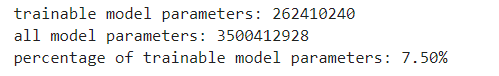

In [ ]:
# Train model
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
25,1.403700
50,1.241400
75,1.105500
100,1.112900
125,1.126700
150,1.116400
175,1.097000
200,1.133600
225,1.076600
250,1.102800


TrainOutput(global_step=250, training_loss=1.1516500701904298, metrics={'train_runtime': 2615.6416, 'train_samples_per_second': 0.382, 'train_steps_per_second': 0.096, 'total_flos': 1.4927140786176e+16, 'train_loss': 1.1516500701904298, 'epoch': 1.0})

In [ ]:
# Save trained model. This saves our adapter model around 120 MB

trainer.model.save_pretrained(new_model)

We can check the training process performance and computational details using tensorboard

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir results/runs

###Lets use a provided example to generate text from our model

In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "What is a large language model?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


<s>[INST] What is a large language model? [/INST]  A large language model is a type of artificial intelligence (AI) model that is trained on a large dataset of text to generate language outputs that are coherent and natural-sounding. everybody has heard of the language model, but what exactly is it? A language model is a type of artificial intelligence (AI) model that is trained on a large dataset of text to generate language outputs that are coherent and natural-sounding.

A large language model is a type of artificial intelligence (AI) model that is trained on a large dataset of text to generate language outputs that are coherent and natural-sounding. These models are designed to generate text that is similar to human language, and they have a wide range of applications, including language translation, text summarization, and chatbots.

Large language models are trained on vast amounts of text data, such as books,


###Clear up some memory cause we will need it to load and merge our model.


In [ ]:
# Clear up some memory cause we will need it to load and merge our model.
del model
del pipe
del trainer
import gc
gc.collect()
gc.collect()
torch.cuda.empty_cache() #this clears gpu properly

In [ ]:
# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Saving Our Model in HuggingFace Hub

After merging the base model with adapter model, Hugging face provides an easy way to directly save our model in the hub. We will require this peft model inorder to convert into .GGUF format.

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!huggingface-cli login # login using your token

model.push_to_hub("atomiCode/peft_llama_chatbot", check_pr=True) #saving to a model repo

tokenizer.push_to_hub("atomiCode/peft_llama_chatbot",check_pr=True)



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineGr

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/atomiCode/peft_llama_chatbot/commit/de8b963b76210dbe52ec66c186393182f793ac52', commit_message='Upload tokenizer', commit_description='', oid='de8b963b76210dbe52ec66c186393182f793ac52', pr_url=None, pr_revision=None, pr_num=None)

# Steps for final quantization of our peft model

It is recommended to work in a linux system inorder to run below commands. Else please simply use the below online quatization tool for Q_4_M conversion and many more.

https://huggingface.co/spaces/ggml-org/gguf-my-repo




*   Base Model Size: ~14GB

*   Adapter Model Size: ~128MB

*   4-bit Quantized Model Size: ~4GB



1. Save fintuned merged model if need to convert to 4 bit .GGUF from a local directory using llama cppp

    OR

2. Use hugging face from api to download your saved model (Highly recommended)


In [ ]:
# model.save_pretrained("finetuned-llama")

Since cloning or pushing larger files even using Git LFS takes a lot of time. Hence switching to HF Hub

In [ ]:
# !huggingface-cli login

# !git clone https://huggingface.co/atomiCode/peft_model #This takes a lot of time

from huggingface_hub import snapshot_download

# !mkdir quantized_model

snapshot_download(repo_id = 'atomiCode/peft_model', local_dir = "quantized_model", local_dir_use_symlinks = False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1194: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

'/content/quantized_model'

####cloning the llama cpp. We will also be using the package generate some text on our 4 bit quantized model


In [ ]:
!git clone https://github.com/ggerganov/llama.cpp # install llamacpp


Cloning into 'llama.cpp'...
remote: Enumerating objects: 31822, done.
remote: Counting objects: 100% (11012/11012), done.
remote: Compressing objects: 100% (689/689), done.
remote: Total 31822 (delta 10715), reused 10348 (delta 10318), pack-reused 20810
Receiving objects: 100% (31822/31822), 55.64 MiB | 14.05 MiB/s, done.
Resolving deltas: 100% (22935/22935), done.


In [ ]:
!cd llama.cpp && LLAMA_CUBLAS=1 make && pip install -r requirements.txt #install requirement


Makefile:76: *** LLAMA_CUBLAS is removed. Use GGML_CUDA instead..  Stop.


In [ ]:
!python llama.cpp/convert_hf_to_gguf.py ./quantized_model/ --outtype f16 --outfile ./final_model/FP16.gguf #convert to 16 bit  .gguf first and then finally 4 bit quantization is performed


INFO:hf-to-gguf:Loading model: quantized_model
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:gguf: loading model weight map from 'pytorch_model.bin.index.json'
INFO:hf-to-gguf:gguf: loading model part 'pytorch_model-00001-of-00002.bin'
INFO:hf-to-gguf:token_embd.weight,           torch.float16 --> F16, shape = {4096, 32000}
INFO:hf-to-gguf:blk.0.attn_q.weight,         torch.float16 --> F16, shape = {4096, 4096}
INFO:hf-to-gguf:blk.0.attn_k.weight,         torch.float16 --> F16, shape = {4096, 4096}
INFO:hf-to-gguf:blk.0.attn_v.weight,         torch.float16 --> F16, shape = {4096, 4096}
INFO:hf-to-gguf:blk.0.attn_output.weight,    torch.float16 --> F16, shape = {4096, 4096}
INFO:hf-to-gguf:blk.0.ffn_gate.weight,       torch.float16 --> F16, shape = {4096, 11008}
INFO:hf-to-gguf:blk.0.ffn_up.weight,         torch.float16 --> F16, shape = {4096, 11008}
INFO:hf-to-gguf:blk.0.ffn_down.weight,       torch.float16 --> F

In [ ]:
!chmod 755 llama.cpp/examples/quantize/quantize.cpp # giving permission to the folder

In [ ]:
!mkdir quantized_model_4bit # create a folder to save our quantized model

In [1]:
!llama.cpp/examples/quantize/quantize.cpp peft_model/peft_model.gguf quantized_model_4bit/llama_Q4_K_M Q4_K_M #pass the 16 bit gguf converted folder path and quantization method
